In [1]:
import json
import shelve

import matplotlib.pyplot as plt

from data.ag.action_genome import AG, AGViewer

%load_ext autoreload





In [2]:
root = '/data/Datasets/ag/'
subset_filename = 'data/ag/subset.json'
ag = AG(root)

['person', 'bag', 'bed', 'blanket', 'book', 'box', 'broom', 'chair', 'closet/cabinet', 'clothes', 'cup/glass/bottle', 'dish', 'door', 'doorknob', 'doorway', 'floor', 'food', 'groceries', 'laptop', 'light', 'medicine', 'mirror', 'paper/notebook', 'phone/camera', 'picture', 'pillow', 'refrigerator', 'sandwich', 'shelf', 'shoe', 'sofa/couch', 'table', 'television', 'towel', 'vacuum', 'window']
{0: None, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15: 15, 16: 16, 17: 17, 18: None, 19: None, 20: 18, 21: 19, 22: 20, 23: 21, 24: 22, 25: 23, 26: 24, 27: 25, 28: 26, 29: 27, 30: 28, 31: 29, 32: 30, 33: 31, 34: 32, 35: 33, 36: 34, 37: 35}
folder /data/Datasets/ag/frames/00SL4.mp4 does not exist
folder /data/Datasets/ag/frames/00SL4.mp4 does not exist
folder /data/Datasets/ag/frames/00SL4.mp4 does not exist
folder /data/Datasets/ag/frames/00SL4.mp4 does not exist
folder /data/Datasets/ag/frames/00SL4.mp4 does not exist
folder /data/Datasets/ag/fram

In [3]:
for a in ag.action_classes:
    print(a)

c000 Holding some clothes
c001 Putting clothes somewhere
c002 Taking some clothes from somewhere
c003 Throwing clothes somewhere
c004 Tidying some clothes
c005 Washing some clothes
c006 Closing a door
c007 Fixing a door
c008 Opening a door
c009 Putting something on a table
c010 Sitting on a table
c011 Sitting at a table
c012 Tidying up a table
c013 Washing a table
c014 Working at a table
c015 Holding a phone/camera
c016 Playing with a phone/camera
c017 Putting a phone/camera somewhere
c018 Taking a phone/camera from somewhere
c019 Talking on a phone/camera
c020 Holding a bag
c021 Opening a bag
c022 Putting a bag somewhere
c023 Taking a bag from somewhere
c024 Throwing a bag somewhere
c025 Closing a book
c026 Holding a book
c027 Opening a book
c028 Putting a book somewhere
c029 Smiling at a book
c030 Taking a book from somewhere
c031 Throwing a book somewhere
c032 Watching/Reading/Looking at a book
c033 Holding a towel/s
c034 Putting a towel/s somewhere
c035 Taking a towel/s from somewh

In [4]:
for a in ag.verb_classes:
    print(a)

v000 awaken
v001 close
v002 cook
v003 dress
v004 drink
v005 eat
v006 fix
v007 grasp
v008 hold
v009 laugh
v010 lie
v011 make
v012 open
v013 photograph
v014 play
v015 pour
v016 put
v017 run
v018 sit
v019 smile
v020 sneeze
v021 snuggle
v022 stand
v023 take
v024 talk
v025 throw
v026 tidy
v027 turn
v028 undress
v029 walk
v030 wash
v031 watch
v032 work


In [5]:
for a in sorted(ag.action_verb_obj_map.items(), key=lambda x: x[1][0]):
    print(a)

(133, (0, 2))
(146, (0, None))
(6, (1, 12))
(25, (1, 4))
(39, (1, 5))
(46, (1, 18))
(89, (1, 35))
(112, (1, 8))
(142, (1, 26))
(147, (2, 16))
(55, (3, 29))
(148, (3, 9))
(106, (4, 10))
(65, (5, 27))
(129, (5, 20))
(156, (5, 16))
(7, (6, 12))
(103, (6, 19))
(136, (6, 34))
(140, (6, 13))
(144, (6, None))
(141, (7, 13))
(0, (8, 9))
(15, (8, 23))
(20, (8, 1))
(26, (8, 4))
(33, (8, 33))
(40, (8, 5))
(47, (8, 18))
(53, (8, 29))
(61, (8, 16))
(67, (8, 27))
(70, (8, 3))
(76, (8, 25))
(84, (8, 24))
(93, (8, 21))
(98, (8, 6))
(107, (8, 10))
(115, (8, 22))
(118, (8, 11))
(128, (8, 20))
(137, (8, 34))
(85, (9, 24))
(131, (9, 32))
(149, (9, None))
(122, (10, 30))
(124, (10, 15))
(134, (10, 2))
(66, (11, 27))
(8, (12, 12))
(21, (12, 1))
(27, (12, 4))
(41, (12, 5))
(48, (12, 18))
(90, (12, 35))
(113, (12, 8))
(143, (12, 26))
(87, (13, 23))
(16, (14, 23))
(52, (14, 18))
(108, (15, 10))
(1, (16, 9))
(9, (16, 31))
(17, (16, 23))
(22, (16, 1))
(28, (16, 4))
(34, (16, 33))
(42, (16, 5))
(49, (16, 18))
(54

In [6]:
for b in ag.object_classes:
    print(b)

person
bag
bed
blanket
book
box
broom
chair
closet/cabinet
clothes
cup/glass/bottle
dish
door
doorknob
doorway
floor
food
groceries
laptop
light
medicine
mirror
paper/notebook
phone/camera
picture
pillow
refrigerator
sandwich
shelf
shoe
sofa/couch
table
television
towel
vacuum
window


In [7]:
print(len(ag))

33432


INDEX: 33379
LABEL: UNMARKED
ACTION: c151 Someone is going from standing to sitting
VERB-OBJ: v018 sit None
VIDEO-FRAME-ACTION ID: B4F0T.mp4/000430.png_151
[('person', 'looking_at', 'cup/glass/bottle'), ('cup/glass/bottle', 'in_front_of', 'person'), ('person', 'holding', 'cup/glass/bottle'), ('person', 'touching', 'cup/glass/bottle')]


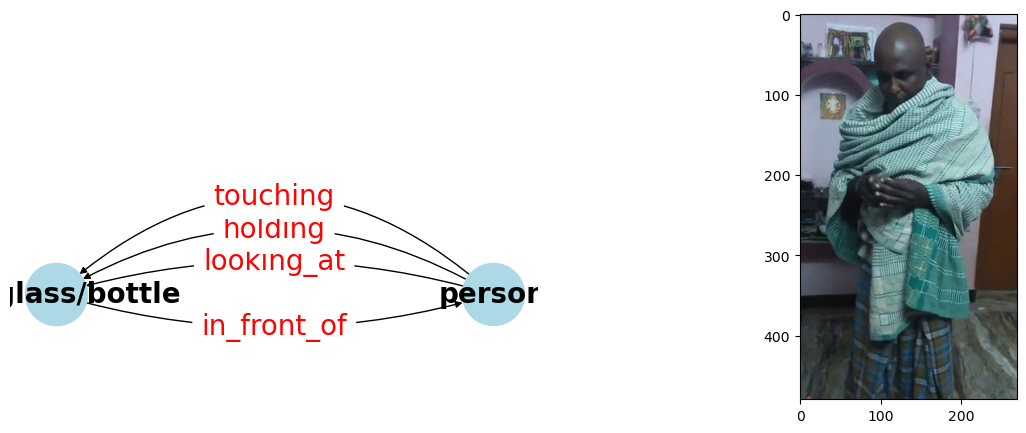

In [16]:
%autoreload

with shelve.open('data/ag/subset_shelve') as subset_dict:
    agview = AGViewer(ag, subset_dict)
    agview.view(0)
    while True:
        answer = input(f"{agview.message}current search key : {str(agview.key)}")
        new_idx = agview.process_command(answer)
        if new_idx is not None:
            agview.view(new_idx)
        else:
            break


In [15]:
#apply some initial heuristics
with shelve.open('data/ag/subset_shelve') as subset_dict:
    count = 0
    for idx in range(len(ag)):
        id, img, sg, action = ag[idx]

        verb, obj = ag.action_verb_obj_map[action]

        if obj is not None and obj not in sg.node_type:
            print('DEFECT FOUND:', idx)
            subset_dict[id] = 'False'
            count+=1
            continue

print('TOTAL DEFECTS:', count)

DEFECT FOUND: 0
DEFECT FOUND: 1
DEFECT FOUND: 4
DEFECT FOUND: 5
DEFECT FOUND: 17
DEFECT FOUND: 18
DEFECT FOUND: 24
DEFECT FOUND: 26
DEFECT FOUND: 28
DEFECT FOUND: 33
DEFECT FOUND: 35
DEFECT FOUND: 40
DEFECT FOUND: 43
DEFECT FOUND: 45
DEFECT FOUND: 49
DEFECT FOUND: 51
DEFECT FOUND: 53
DEFECT FOUND: 56
DEFECT FOUND: 58
DEFECT FOUND: 59
DEFECT FOUND: 60
DEFECT FOUND: 61
DEFECT FOUND: 62
DEFECT FOUND: 63
DEFECT FOUND: 65
DEFECT FOUND: 66
DEFECT FOUND: 67
DEFECT FOUND: 68
DEFECT FOUND: 69
DEFECT FOUND: 70
DEFECT FOUND: 71
DEFECT FOUND: 72
DEFECT FOUND: 73
DEFECT FOUND: 74
DEFECT FOUND: 75
DEFECT FOUND: 80
DEFECT FOUND: 81
DEFECT FOUND: 86
DEFECT FOUND: 91
DEFECT FOUND: 95
DEFECT FOUND: 97
DEFECT FOUND: 106
DEFECT FOUND: 109
DEFECT FOUND: 110
DEFECT FOUND: 111
DEFECT FOUND: 113
DEFECT FOUND: 116
DEFECT FOUND: 117
DEFECT FOUND: 118
DEFECT FOUND: 126
DEFECT FOUND: 134
DEFECT FOUND: 135
DEFECT FOUND: 136
DEFECT FOUND: 138
DEFECT FOUND: 144
DEFECT FOUND: 145
DEFECT FOUND: 146
DEFECT FOUND: 149
D

In [22]:
action_hist = {}
for idx in range(len(ag)):
    id, img, sg, action = ag[idx]

    if action not in action_hist:
        action_hist[action] = 0
    action_hist[action]+=1

In [32]:
sorted_actions = sorted(action_hist.items(), key=lambda x: x[1], reverse=True)

for k,v in sorted_actions:
    print(ag.action_classes[k], v)
#plt.hist(list(action_hist.values()), bins=range(1, 10))


c097 Walking through a doorway 1095
c154 Someone is standing up from somewhere 997
c106 Drinking from a cup/glass/bottle 833
c151 Someone is going from standing to sitting 714
c009 Putting something on a table 711
c152 Someone is smiling 684
c061 Holding some food 679
c156 Someone is eating something 633
c059 Sitting in a chair 633
c107 Holding a cup/glass/bottle of something 626
c008 Opening a door 586
c063 Taking food from somewhere 550
c015 Holding a phone/camera 540
c006 Closing a door 499
c001 Putting clothes somewhere 489
c118 Holding a dish 478
c153 Someone is sneezing 451
c113 Opening a closet/cabinet 450
c000 Holding some clothes 425
c110 Taking a cup/glass/bottle from somewhere 423
c020 Holding a bag 416
c062 Putting some food somewhere 406
c081 Putting something on a shelf 389
c109 Putting a cup/glass/bottle somewhere 384
c149 Someone is laughing 383
c141 Grasping onto a doorknob 372
c016 Playing with a phone/camera 369
c119 Putting a dish/es somewhere 368
c002 Taking some c

In [9]:
#convert to shelve

filename = 'data/ag/subset.json'

# Step 1: Load the JSON-stored dictionary
with open(filename, 'r') as json_file:
    json_dict = json.load(json_file)  # Load the JSON file into a Python dictionary

# Step 2: Create and populate a shelve file
with shelve.open('data/ag/subset_shelve') as shelve_file:  # This creates a new shelve file (or opens an existing one)
    for key, value in json_dict.items():
        shelve_file[key] = str(value) # Store each key-value pair in the shelve file

print("JSON dictionary successfully converted to a shelve file!")

JSON dictionary successfully converted to a shelve file!
